In [84]:
import warnings
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.datapath import (
    model_built_data_paths,
    model_ready_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [85]:
asset_type = "building"
years_ahead = 2

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

# metric_key_unsmoothed = "weighted_median"
metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric

In [86]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_built_data_path = model_built_data_paths[dataset_name]

df = pd.read_csv(model_built_data_path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)


In [87]:
columns = [
    metric_pct_chg,
    metric,
    metric_unsmoothed,
    "year",
    "years_since_crisis",
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "total_tax",
    "total_tax_growth",
    "new_dwellings",
    "existing_dwellings",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "area_code",  # id
    "area", # additional info
]

<Axes: ylabel='Frequency'>

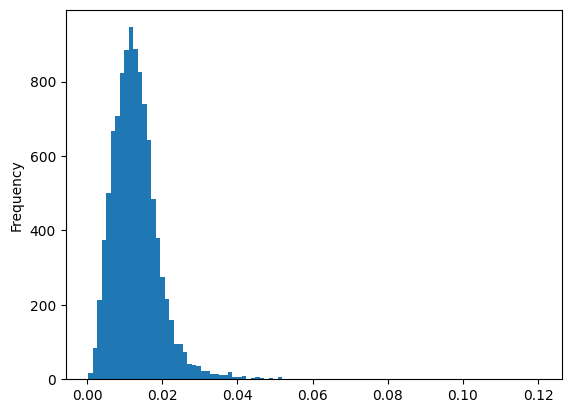

In [88]:
column = "new_dwellings_ratio"
log_column = f"log_{column}"
df[column].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

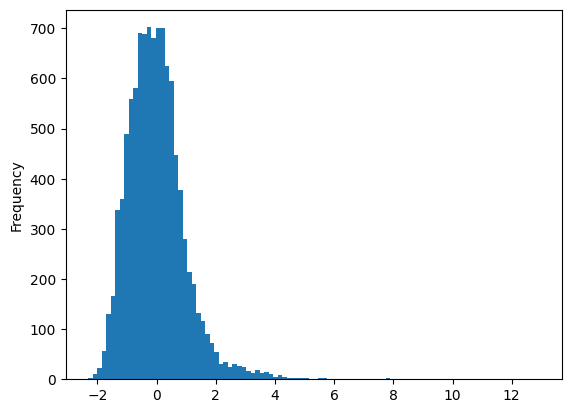

In [89]:
df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
    lambda x: (x - x.mean()) / x.std()
)
df[f"{column}_normalized_yearly"].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

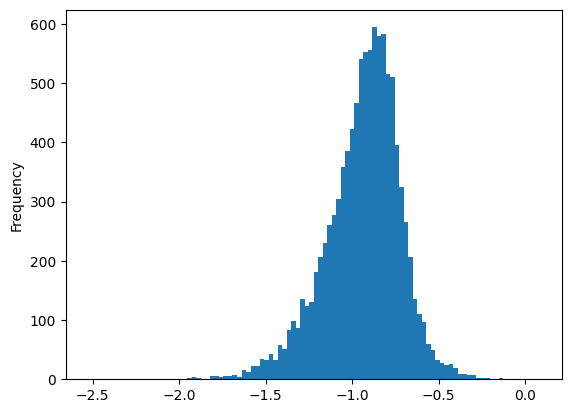

In [90]:
df[log_column] = df[column].apply(lambda x: 1 + np.log10(x))
df[log_column].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

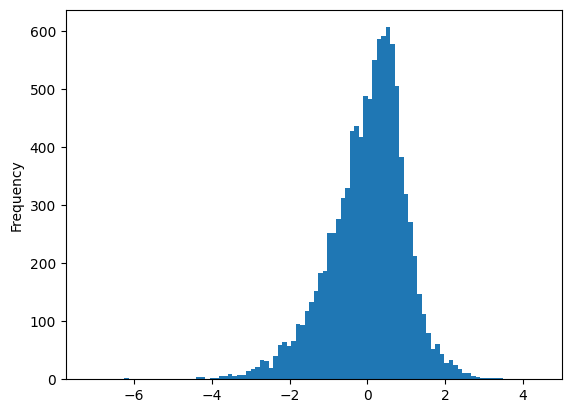

In [91]:
df[f"{log_column}_normalized_yearly"] = df.groupby("year")[log_column].transform(
    lambda x: (x - x.mean()) / x.std()
)
df[f"{log_column}_normalized_yearly"].plot.hist(bins=100)

In [98]:
# log_normalize_columns = [
#     metric,
#     "count",
#     "total_traded_area",
#     "population",
#     "taxpayer_count",
#     "taxable_income",
#     "taxable_income_per_taxpayer",
#     "total_tax",
#     "new_dwellings",
#     "existing_dwellings",
# ]

# normalize_columns = [
#     metric_pct_chg,
#     "total_tax_growth",
#     "taxable_income_growth",
#     "taxable_income_per_taxpayer_growth",
#     "net_migration_ratio",
#     "new_dwellings_ratio",
# ]

log_normalize_columns = []

normalize_columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
]

maintain_columns = [
    metric_pct_chg,
    "years_since_crisis",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

id_columns = [
    "area_code",
    "area",
    "year",
]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
)

final_columns = id_columns + feature_columns

In [99]:
for column in log_normalize_columns:
    df[f"{column}_log"] = df[column].apply(lambda x: 1 + np.log10(x))
    df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

for column in normalize_columns:
    df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
        lambda x: (x - x.mean()) / x.std()
    )

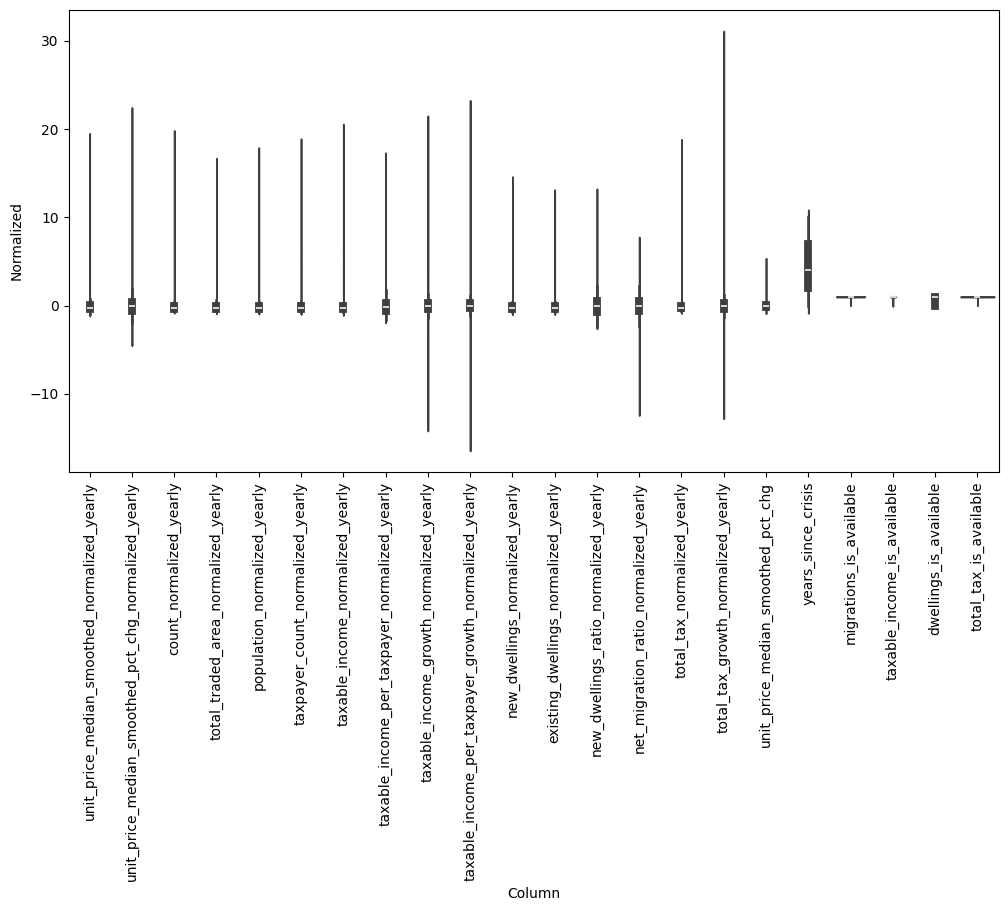

In [100]:
df_std = df[feature_columns].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[feature_columns].keys(), rotation=90)

In [101]:
df[final_columns].describe()

,area_code,year,unit_price_median_smoothed_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,count_normalized_yearly,total_traded_area_normalized_yearly,population_normalized_yearly,taxpayer_count_normalized_yearly,taxable_income_normalized_yearly,taxable_income_per_taxpayer_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,new_dwellings_normalized_yearly,existing_dwellings_normalized_yearly,new_dwellings_ratio_normalized_yearly,net_migration_ratio_normalized_yearly,total_tax_normalized_yearly,total_tax_growth_normalized_yearly,unit_price_median_smoothed_pct_chg,years_since_crisis,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
count,18826.000000,18826.000000,1.882600e+04,1.882600e+04,1.882600e+04,1.882600e+04,1.878200e+04,1.741000e+04,1.741000e+04,1.741000e+04,1.741000e+04,1.741000e+04,1.037800e+04,1.037800e+04,1.037800e+04,1.878200e+04,1.879000e+04,1.877800e+04,18826.000000,18826.000000,18826.000000,18826.000000,18826.000000,18826.000000
mean,21603.518963,2015.617125,4.151689e-18,6.604960e-19,-8.680805e-18,-2.830697e-18,-9.363184e-18,8.417544e-18,3.009910e-18,1.644737e-16,1.678407e-17,3.224174e-17,-2.225153e-18,4.279141e-18,-3.149447e-17,-3.121061e-17,-2.008919e-18,-7.757017e-18,-0.002124,4.430947,0.997663,0.924785,0.551259,0.998088
std,13633.134424,3.973032,9.996015e-01,9.996015e-01,9.996015e-01,9.996015e-01,9.996006e-01,9.995978e-01,9.995978e-01,9.995978e-01,9.995978e-01,9.995978e-01,9.993252e-01,9.993252e-01,9.993252e-01,9.996006e-01,9.996008e-01,9.996005e-01,0.215441,3.095357,0.048289,0.263745,0.497379,0.043689
min,1100.000000,2007.000000,-8.959121e-01,-4.265657e+00,-5.836907e-01,-6.568131e-01,-6.771900e-01,-7.122424e-01,-8.349070e-01,-1.668048e+00,-1.391518e+01,-1.618057e+01,-7.193996e-01,-7.065652e-01,-2.314005e+00,-1.217066e+01,-6.089259e-01,-1.253148e+01,-0.846925,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11100.000000,2012.000000,-4.082514e-01,-5.477251e-01,-3.593063e-01,-4.214527e-01,-3.605497e-01,-3.596872e-01,-3.338540e-01,-5.846221e-01,-3.508519e-01,-3.008739e-01,-3.751833e-01,-3.786649e-01,-6.685586e-01,-5.841954e-01,-2.954618e-01,-3.513131e-01,-0.118428,2.000000,1.000000,1.000000,0.000000,1.000000
50%,21202.500000,2016.000000,-2.834885e-01,-5.544731e-02,-2.772067e-01,-2.855825e-01,-2.689266e-01,-2.700762e-01,-2.638490e-01,-1.893084e-01,-2.366536e-02,-2.932723e-02,-2.795313e-01,-2.862851e-01,-8.987009e-02,-2.066081e-02,-2.332596e-01,-5.026445e-02,-0.015540,4.000000,1.000000,1.000000,1.000000,1.000000
75%,32501.000000,2019.000000,6.018910e-02,4.155062e-01,-2.569294e-02,1.273997e-02,-4.595516e-02,-4.588181e-02,-6.652081e-02,3.458207e-01,3.159421e-01,2.526689e-01,-4.570991e-02,-3.900307e-02,4.916479e-01,5.345171e-01,-5.030366e-02,2.769748e-01,0.087146,7.000000,1.000000,1.000000,1.000000,1.000000
max,47362.000000,2022.000000,1.926202e+01,2.218303e+01,1.958060e+01,1.643900e+01,1.763072e+01,1.864439e+01,2.030456e+01,1.704310e+01,2.124002e+01,2.299408e+01,1.431292e+01,1.283672e+01,1.292711e+01,7.519474e+00,1.858611e+01,3.085368e+01,5.327160,10.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
df = df.fillna(0)
# df.to_csv(model_ready_data_paths[f"sequence_{dataset_key}_{metric_key}_{years_ahead}"], index=False)

In [103]:
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)].reset_index(drop=True)
eval_df = df[df["year"] >= eval_start_year].reset_index(drop=True)

In [104]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
2,2007,2.204983e+06,0.227171,2.619291
127,2008,2.197454e+06,0.139858,1.066988
207,2009,2.069647e+06,-0.061378,-0.060949
1627,2010,1.825045e+06,-0.169473,-0.456003
3215,2011,1.620211e+06,-0.217156,-0.780465
4005,2012,1.684720e+06,-0.076888,-0.332538
6055,2013,1.947510e+06,0.202010,1.113350
7546,2014,2.130575e+06,0.264646,1.446387
7968,2015,2.257352e+06,0.159097,0.843063
9316,2016,2.645833e+06,0.241840,1.197871


In [105]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
690,2020,3.849920e+06,0.257623,1.115681
2102,2021,4.164547e+06,0.225359,0.829393
2997,2022,4.462737e+06,0.159177,0.495757


In [107]:
idx = 2997
row = eval_df.iloc[idx]
target = row[metric_pct_chg + "_normalized_yearly"]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window[feature_columns]

Target: 0.49575667557701153


,unit_price_median_smoothed_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,count_normalized_yearly,total_traded_area_normalized_yearly,population_normalized_yearly,taxpayer_count_normalized_yearly,taxable_income_normalized_yearly,taxable_income_per_taxpayer_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,new_dwellings_normalized_yearly,existing_dwellings_normalized_yearly,new_dwellings_ratio_normalized_yearly,net_migration_ratio_normalized_yearly,total_tax_normalized_yearly,total_tax_growth_normalized_yearly,unit_price_median_smoothed_pct_chg,years_since_crisis,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
9316,16.231302,1.197871,-0.112194,-0.270920,-0.141833,-0.068699,0.495869,11.254159,3.326466,2.794484,0.166267,-0.224698,3.656181,2.891238,0.120195,1.241271,0.241840,8,1,1,1,1
11596,16.441401,1.325756,-0.162684,-0.309082,-0.137364,-0.063243,0.528746,11.600381,1.078699,0.662914,0.127092,-0.217599,3.723002,3.529738,0.130960,0.600038,0.264897,9,1,1,1,1
13235,17.107678,0.792784,-0.147566,-0.301729,-0.131970,-0.057451,0.580891,12.174159,1.386379,1.047246,-0.047967,-0.211087,1.645595,6.184275,0.122456,0.767497,0.157014,10,1,1,1,1
13654,18.154210,0.999511,-0.152671,-0.304405,-0.122051,-0.042800,0.684955,12.791935,3.300568,2.262774,-0.100765,-0.209348,1.240900,5.265364,0.152989,2.562201,0.190282,0,1,1,1,1
15423,19.194516,1.115681,-0.267504,-0.439973,-0.113077,-0.028823,0.642811,12.087830,-1.113892,-2.871377,0.098979,-0.204701,3.489141,3.201692,0.134451,-1.299834,0.257623,1,1,1,1,1
